# Text Feature Extraction Using ULMFit


This notebook demonstrates how to use `thai2fit` to convert Thai texts into vectors, after which said vectors can be used for various machine learning tasks such as classification, clustering, translation, question answering and so on. The idea is to train a language model that "understands" the texts then extract certain vectors that the model "thinks" represents the texts we want. We use 113,962 product reviews scraped from an ecommerce website as our sample dataset. 

Our workflow is as follows:

* Perform 85/15 train-validation split
* Minimal text cleaning and tokenization using `newmm` engine of `pyThaiNLP`
* Get embeddings of ecommerce dataset from train set
* Load pretrained Thai Wikipedia embeddings; for those embeddings which exist only in ecommerce dataset, we use the average of Wikipedia embeddings instead
* Train language model
* Cut out the encoder and extract vectors from there.

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import dill as pickle
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import trange

from fastai import *
from fastai.text import *
import pythainlp
from pythainlp.ulmfit import *


DATA_PATH='../sent_data/'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}models/'

## Dataset

The training data consists of 29,415 reviews from unknown number of reviewers relabled by us as positive (`1`) or negative (`0`). We use 85/15 train-validation split. The validation set has 5,192 reviews. No information accuracy is 52.5%. The dataset can be downloded [here](https://www.dropbox.com/s/onrddd8h3hezccn/sent_raw.csv?dl=0).

Data path structure should be
* `sent_data`
    * `raw`: save the file here as `sent_raw.csv`
    * `models`: store models

In [2]:
df = pd.read_csv(f'{RAW_PATH}sent_raw.csv')
df = df.drop('src',1)
df.query('target==1').tail()

,target,text
34526,1,พึ่งไปทานมาเมื่ออาทิตย์ที่แล้ว อร่อยมากเลยค่ะ
34527,1,เมื่อวานไปทานที่the mall บางกะปิ พนักงานน่ารัก...
34528,1,กินที่บางกะปิมา พนักงานใจดีทุกคนเลย
34529,1,ดีมากๆเรย สาขาเซนแจ้งพนักงานเฟรนลี่ทุกคนเรย
34530,1,อาหารอร่อยมีให้เลือกเยอะมาก


In [3]:
df.query('target==0').tail()

,target,text
34602,0,เอาของเก่ามาขาย ใช้น้ำมันเก่ามาทอด ขายให้ลูกค้...
34603,0,แอดมินเพจทำงานแย่มากนะคะ ไม่อินบ๊อกซ์แจ้งผู้โช...
34604,0,ไปซื้อพิซซ่า สาขาถ.จันทร์ สั่งพิซซ่ามาสองกล่อง...
34605,0,พนักงานน่ายังกะส้นตีน สงสัยทะเลาะกับผัวมา พูดอ...
34606,0,รับปรุงด่วนเลยครับ เรื่องเวลาเสริฟให้ลูกค้า นา...


In [4]:
print(df.shape)
cnt = Counter(df['target'])
cnt

(34607, 2)


Counter({1: 16451, 0: 18156})

In [5]:
#baseline
cnt.most_common(1)[0][1] / df.shape[0]

0.5246337446181408

In [6]:
#train/validation/train_language_model split for fasttext
df_trn, df_val = train_test_split(df, test_size = 0.15, random_state = 1412)

df.to_csv(f'{DATA_PATH}df_all.csv', header=False, index=False)
df_trn.to_csv(f'{DATA_PATH}train.csv', header=False, index=False)
df_val.to_csv(f'{DATA_PATH}valid.csv', header=False, index=False)

## Language Modeling

### Text Processing

We first determine the vocab for the reviews, then train a language model based on our training set. We perform the following  text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

In [7]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', rules = thai_rules)
# data_lm = TextLMDataBunch.from_csv(path = Path(DATA_PATH),csv_name='df_all.csv',valid_pct=0.1,
#                                   tokenizer=tt, vocab = None)
# data_lm.save('sent_lm')

In [8]:
data_lm = TextLMDataBunch.load(DATA_PATH,'sent_lm',bs=64)

In [9]:
len(data_lm.vocab.itos)

11123

In [10]:
len(data_lm.valid_ds), len(data_lm.train_ds)

(3461, 31145)

### Load Pretrained Language Model

Instead of starting from random weights, we import the language model pretrained on Wikipedia (see `pretrained_wiki.ipynb`). For words that appear only in the Wongnai dataset but not Wikipedia, we start with the average of all embeddings instead.

In [11]:
#get pretrained models via pythainlp
model_path,itos_path = pythainlp.ulmfit._THWIKI_LSTM

wgts = torch.load(f'{model_path}.pth', map_location=lambda storage, loc: storage)
itos_lstm = pickle.load(open(f'{itos_path}.pkl','rb'))
wgts = merge_wgts(300, wgts, itos_lstm, data_lm.vocab.itos)
wgts['0.encoder.weight'].shape, len(wgts.keys())

(torch.Size([11123, 300]), 18)

### Train Domain-Specific Language Model

In [12]:
#heuristic reference from imdb_scripts
learn = language_model_learner(data_lm, bptt = 70, emb_sz = 300, nh = 1150, nl = 3,
                                  drop_mult = 0.7, bias = False, qrnn = False, 
                                  alpha=2, beta = 1,
                                  pretrained_fnames = None)
learn.metrics = [accuracy]
learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))
learn.wd = 1e-7
#VERY IMPORTANT TO LOAD PRETRAINED WEIGHTS
learn.model.load_state_dict(wgts)

If you want to use the QRNN version use the following `language_model_learner` instead.

In [13]:
# learn = language_model_learner(data_lm, bptt = 70, emb_sz = 400, nh = 1550, nl = 3,
#                                   drop_mult = 0.3, bias = True, qrnn = True, 
#                                   alpha=2, beta = 1,
#                                   pretrained_fnames = pythainlp.ulmfit._THWIKI_QRNN)
# learn.metrics = [accuracy]
# learn.opt_func = partial(optim.Adam, betas=(0.8, 0.99))
# learn.wd = 1e-7

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


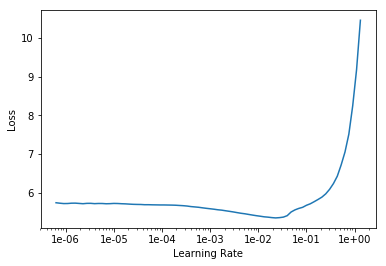

In [18]:
learn.lr_find()
learn.recorder.plot()

In [23]:
#optimal learning rate and wd
lr = 0.05 / 10
wd = 1e-7
learn.freeze()

In [24]:
#train frozen to warm up
learn.fit_one_cycle(cyc_len = 1, 
                    max_lr= lr, #learning rate
                    div_factor=20, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = wd #weight decay
                   ) 

Total time: 01:49
epoch  train_loss  valid_loss  accuracy
1      4.458854    4.235346    0.314211  (01:49)



In [25]:
#train unfrozen
learn.unfreeze()
learn.fit_one_cycle(cyc_len = 3, 
                    max_lr= lr, #learning rate
                    div_factor=20, #factor to discount from max
                    moms = (0.8, 0.7), #momentums
                    pct_start = 0.3, #where the peak is at 
                    wd = wd #weight decay
                   ) 

Total time: 07:00
epoch  train_loss  valid_loss  accuracy
1      4.118326    4.012748    0.332127  (02:20)
2      3.875142    3.810460    0.347802  (02:19)
3      3.633786    3.742740    0.354012  (02:20)



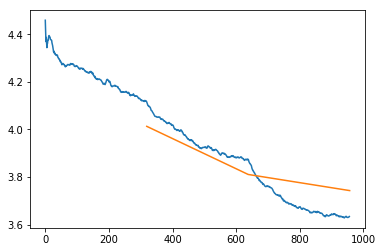

In [26]:
learn.recorder.plot_losses()
learn.save('sent_lm_lstm')
learn.save_encoder('sent_enc_lstm')

### Eye-balling Finetuned Language Model

In order to get a sense of how 'good' our finetuned language model is at understanding domain-specific texts, we can use the model to try predicting the next word and sentence.

In [13]:
learn.load('sent_lm_lstm')
print('LM loaded')

LM loaded


In [14]:
predict_word('ร้านนี้ดี',learn,data_lm, topk =10)

[' ', 'นะ', 'อยู่', 'ครับ', 'ค่ะ', 'ที่', 'เลย', 'มาก', 'ๆ', 'จริงๆ']

In [15]:
''.join(predict_sentence('ร้านนี้',learn,data_lm, nb_words = 15))

'อยู่ในซอยสุขุมวิท 7 (ซอย 7) ร้านอยู่'

## Feature Extraction

Note that we are converting text to vectors without teaching the model any label. Thus, similar sentence structures describing negative and positive sentiments will have "similar" vectors, as opposed to two different sentence structures describing the same sentiment. We use `document_vector` function from pyThaiNLP to extract a vector containing last activations from recurrent layers, their average pooling and their max pooling. This results in a vector of size 900 for LSTM and 1200 for QRNN.

Note that since we have finetuned our model to the current dataset, the document vectors will contain the nuance of the dataset as well, and `document_vector` will return different sets of vectors even for the same text depending on the given contexts.

In [17]:
document_vector('สวัสดีครับพี่น้อง',learn,data_lm)

array([ 0.164493, -0.014595, -0.408335,  0.003117, ..., -0.030505, -0.043111,  0.202248,  0.178486], dtype=float32)

In [18]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a,b):
    return(dot(a, b)/(norm(a)*norm(b)))

v1 = document_vector('สินค้าดีมาก',learn,data_lm)
v2 = document_vector('สินค้าแย่มาก',learn,data_lm)
v3 = document_vector('ใช้ดีมากมาย',learn,data_lm)
v4 = document_vector('สินค้าใช้ดี',learn,data_lm)

print('Same structure; different sentiments: ',cosine_sim(v1,v2))
print('Different structures; same sentiment: ',cosine_sim(v1,v3))
print('Same structure; same sentiment: ',cosine_sim(v1,v4))
print('Different structures; different sentiments: ',cosine_sim(v3,v2))

Same structure; different sentiments:  0.9014295
Different structures; same sentiment:  0.4569781
Same structure; same sentiment:  0.79157925
Different structures; different sentiments:  0.3976805


## Clustering

In cases where we do not know any labels to our data and want to group them solely on their semantic meanings, we can use the features extracted to perform clustering algorithms such as K-means. 

In [19]:
df_val = pd.read_csv(f'{DATA_PATH}valid.csv', header=None)
df_val.columns = ['label','text']
Counter(df_val['label'])

Counter({0: 2696, 1: 2496})

In [20]:
#get all vectors from validation texts
vec_val = []
for i in trange(df_val.shape[0]):
    vec_val.append(document_vector(df_val.iloc[i,1],learn,data_lm).reshape(1,-1))

100%|██████████| 5192/5192 [02:10<00:00, 39.73it/s]


In [21]:
cluster_val = pd.DataFrame(np.concatenate(vec_val,axis=0))
cluster_val.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.535097,-0.136197,-0.446185,0.044141,-0.067302,-0.194638,-0.279915,0.376325,-0.036828,0.088226,...,0.481268,0.449106,0.814791,0.693734,0.086659,0.441821,0.007179,0.079492,0.186464,0.298810
1,-0.054634,-0.029481,-0.197969,-0.012869,-0.026535,0.113078,-0.095109,0.072160,0.145629,-0.147927,...,0.385223,0.736862,0.483078,0.634107,0.305172,0.510675,0.078501,0.304583,0.634858,0.375618
2,0.217892,0.031436,-0.235141,0.006175,-0.025394,0.353443,-0.040134,0.139958,0.262123,-0.157336,...,0.334385,0.597433,0.510765,0.252306,0.270148,0.236903,-0.008031,0.204350,0.355950,0.305278
3,0.167002,0.021036,-0.118601,-0.013135,-0.059470,0.015602,-0.032816,-0.049858,0.408519,-0.113144,...,0.182875,0.029839,0.214211,0.145959,0.240836,0.295539,-0.008271,0.098850,-0.075945,0.315242
4,0.035824,0.037528,-0.362803,0.009906,-0.042432,0.067377,-0.328328,0.173686,0.066588,-0.131918,...,0.322763,0.457890,0.396951,0.690606,0.463087,0.520510,0.083669,0.433494,0.474859,0.228083


100%|██████████| 28/28 [03:53<00:00,  8.34s/it]


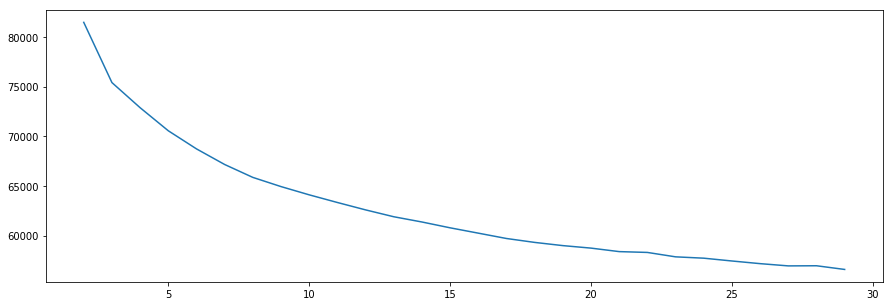

In [22]:
#find optimal number of clusters
from sklearn.cluster import KMeans

inertia = []
for k in trange(2, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cluster_val)
    inertia.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 30), inertia)

In [27]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(cluster_val)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
Counter(kmeans.labels_)

Counter({2: 764, 4: 1563, 3: 1165, 1: 967, 0: 733})

In [29]:
df_val['kmeans_lab']=kmeans.labels_

In [34]:
#bad reviews
df_val.query('kmeans_lab==1').head()

,label,text,kmeans_lab
6,0,ส่งช้ามากๆๆๆๆ10วันกว่าของจะถึง,1
8,0,อยากรุ,1
33,0,สีสวยแต่ไม่ทนค่ะ,1
34,0,ผัดวันประกันพรุ่ง,1
36,0,เลยไม่รู้จะอธิบายยังไง,1


In [35]:
#good reviews
df_val.query('kmeans_lab==3').head()

,label,text,kmeans_lab
2,1,ของส่งเร็วคะ สวยเหมือนในรูป แนะนำเลยคะ,3
3,1,สวย เบา ดีครับ,3
5,1,มันดีมากครับ ใส่สบายเเถมกันนำ้ด้วย มันเยี่ยมมา...,3
9,1,คุ้มค่า ได้รับของเร็วและครบ,3
12,1,มีคุณภาพค่ะ,3
